In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import seaborn as sns


%matplotlib inline

In [45]:
train_df_ = pd.read_csv('train.csv')
test_df_ = pd.read_csv('test.csv')
class_map_df = pd.read_csv('class_map_corrected.csv')
sample_sub_df = pd.read_csv('sample_submission.csv')

In [ ]:
train_df_.head()

In [ ]:
test_df_.head()

In [ ]:
class_map_df.head()

In [ ]:
sample_sub_df.head()

In [ ]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

# Exploratory Data Analysis

In [47]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

In [48]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


# Most used top 10 Grapheme Roots in training set

In [49]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


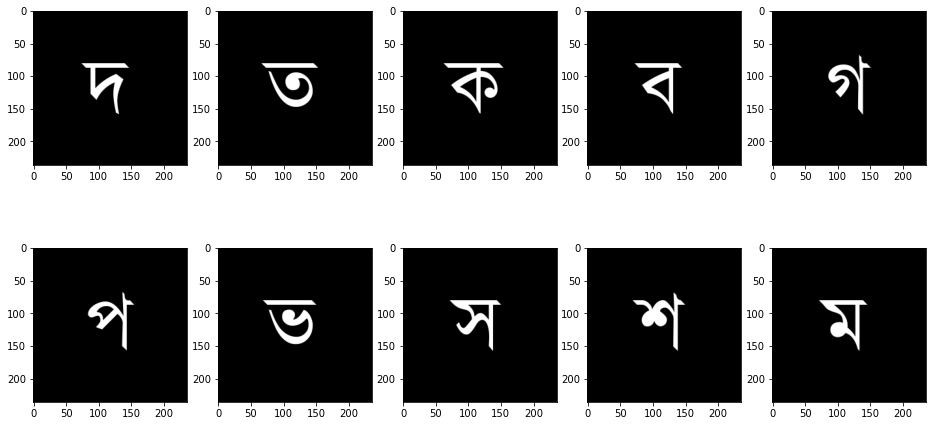

In [50]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

# Least used 10 Grapheme Roots in training set

In [51]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
bottom_10_roots

,index,component,count
73,73,দ্ঘ,130
33,33,ঙ্ক্ত,136
102,102,প্স,141
158,158,স্স,143
45,45,জ্জ্ব,144
130,130,ল্ব,144
1,1,ঃ,145
12,12,ঔ,146
0,0,ং,147
63,63,ণ্ণ,149


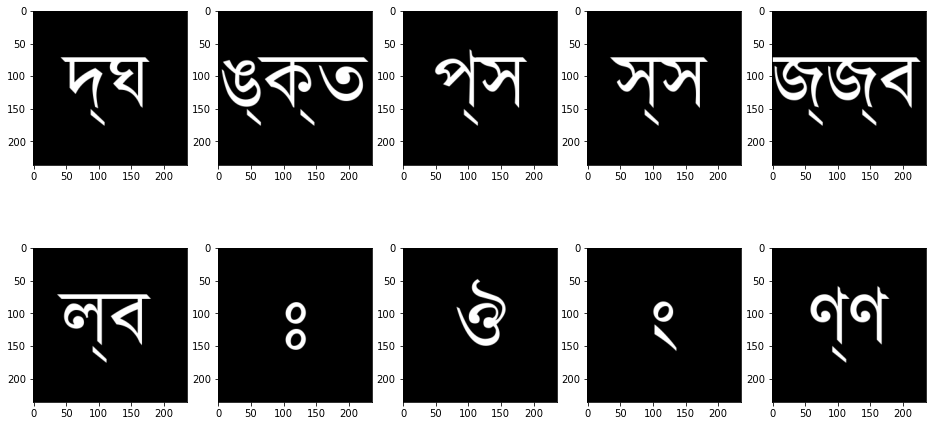

In [52]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

# Top 5 Vowel Diacritic in taining data

In [53]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


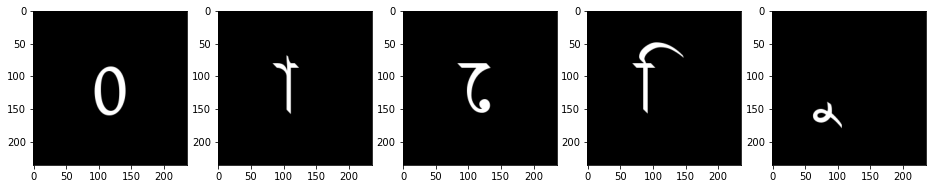

In [54]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

# Top 5 Consonant Diacritic in training data

In [55]:
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


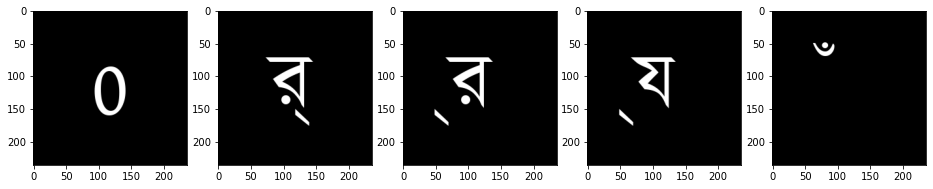

In [56]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_consonants['component'].iloc[i]), cmap='Greys')

In [57]:
df_index=pd.read_csv('train.csv')
df_index

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [58]:
df_index.shape

(200840, 5)

In [59]:
!pwd

/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/src


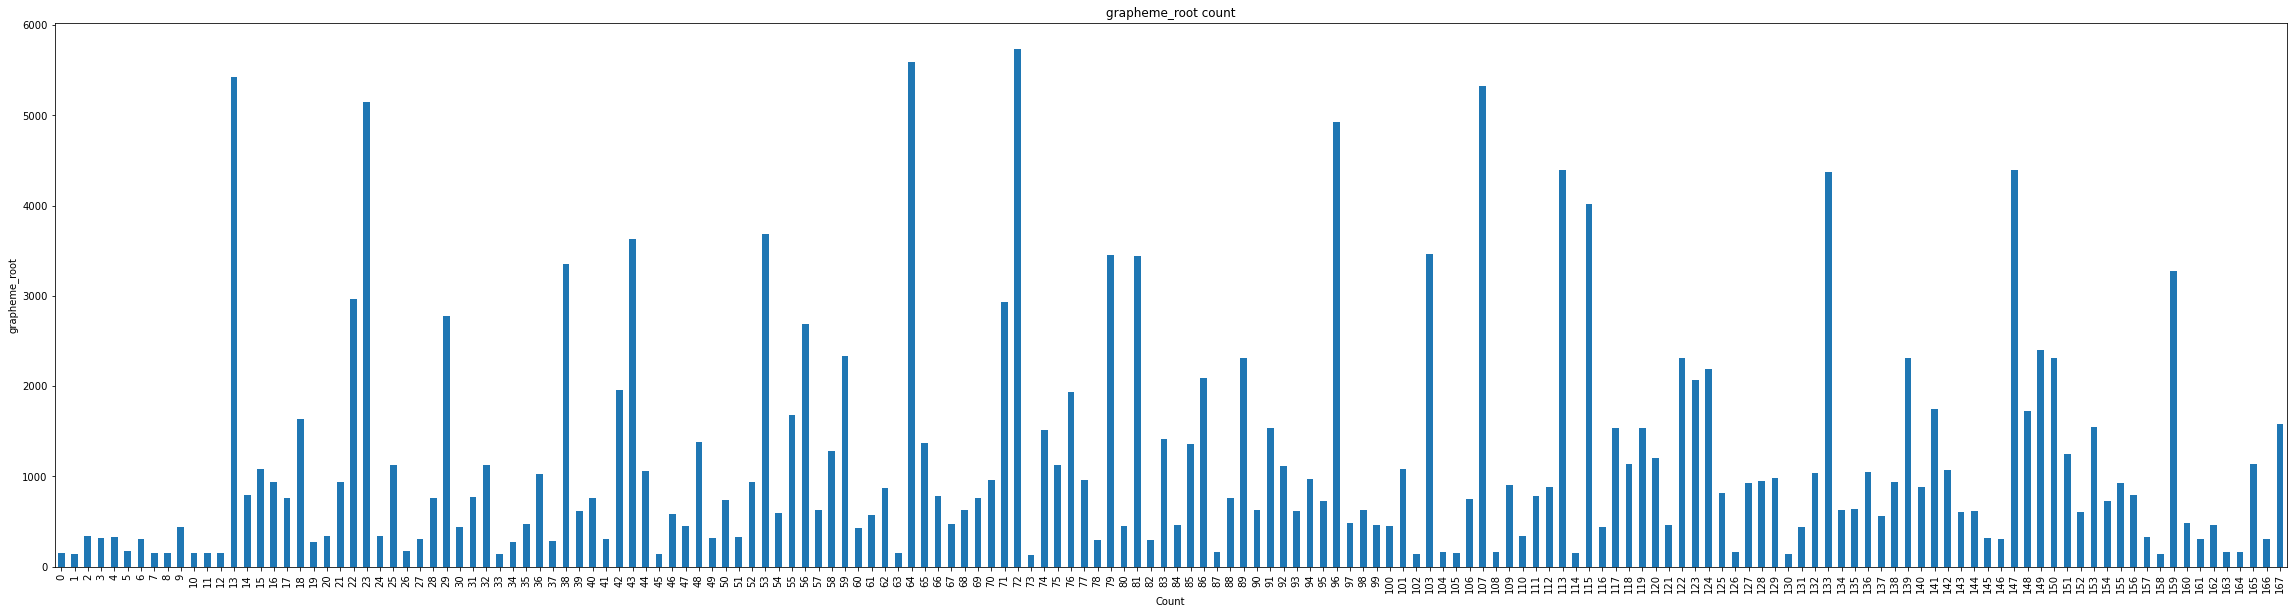

In [60]:
plt.figure(figsize=(40,10))
df_index['grapheme_root'].value_counts().sort_index().plot.bar()
plt.xlabel('Count')
plt.ylabel('grapheme_root')
plt.title('grapheme_root count')
plt.show()


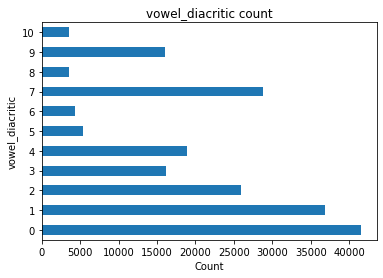

In [61]:
df_index['vowel_diacritic'].value_counts().sort_index().plot.barh()  
plt.xlabel('Count')
plt.ylabel('vowel_diacritic')
plt.title('vowel_diacritic count')
plt.show()
# plt.savefig('/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/src/vowel_diacritic.png');

Text(0.5, 1.0, 'consonant_diacritic count')

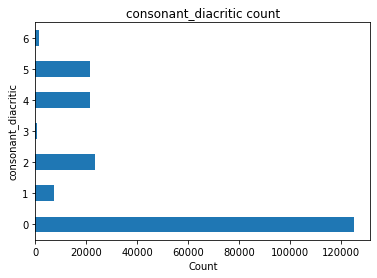

In [62]:
df_index['consonant_diacritic'].value_counts().sort_index().plot.barh()  
plt.xlabel('Count')
plt.ylabel('consonant_diacritic')
plt.title('consonant_diacritic count')

In [63]:
df_index['image_id']=df_index['image_id']+'.png'

In [64]:
df_index

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0.png,15,9,5,ক্ট্রো
1,Train_1.png,159,0,0,হ
2,Train_2.png,22,3,5,খ্রী
3,Train_3.png,53,2,2,র্টি
4,Train_4.png,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835.png,22,7,2,র্খে
200836,Train_200836.png,65,9,0,ত্তো
200837,Train_200837.png,2,1,4,অ্যা
200838,Train_200838.png,152,9,0,স্নো


In [65]:
df_index['consonant_diacritic'].value_counts() 
#7 values , # 7 columns one hot coding, output = 7 colums and softmax

0    125278
2     23465
5     21397
4     21270
1      7424
6      1387
3       619
Name: consonant_diacritic, dtype: int64

In [66]:
df_index.dtypes

image_id               object
grapheme_root           int64
vowel_diacritic         int64
consonant_diacritic     int64
grapheme               object
dtype: object

In [67]:
df_shuffle = df_index.sample(frac=1) #shuffle

In [68]:
train = df_shuffle.iloc[:int(0.8*len(df_index)),:]
test = df_shuffle.iloc[int(0.8*len(df_index)):,:]

In [69]:
len(train)

160672

In [70]:
len(test)

40168

In [71]:
train.sample().shape

(1, 5)

In [72]:
128*128

16384

In [73]:
df_index.head(1)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0.png,15,9,5,ক্ট্রো


# Image Generator  

In [74]:
from PIL import Image 

def mygenerator1(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)
        y1=np.zeros(7)
        y1[sample["consonant_diacritic"].values[0]]=1  
        y1 = y1.astype(np.int32).reshape(1,7) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)
        yield X,y1
# infinite numbers of X and y    

In [75]:
from PIL import Image 

def mygenerator2(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)
        y2=np.zeros(11)
        y2[sample["vowel_diacritic"].values[0]]=1  
        y2 = y2.astype(np.int32).reshape(1,11) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)

        yield X,y2
# infinite numbers of X and y    

In [76]:
from PIL import Image 

def mygenerator3(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)        
        y3=np.zeros(168)
        y3[sample["grapheme_root"].values[0]]=1  
        y3 = y3.astype(np.int32).reshape(1,168) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)
        yield X,y3
# infinite numbers of X and y    

In [77]:
X,y1 = next(mygenerator1(train)) # randomly pick a row 

In [78]:
X.shape

(1, 128, 128, 1)

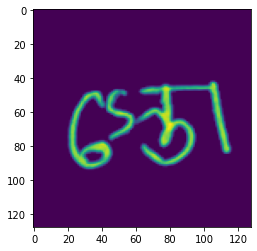

In [79]:
plt.imshow(X[0,:,:,0])

In [80]:
X,y2 = next(mygenerator1(train)) # randomly pick a row X,y1

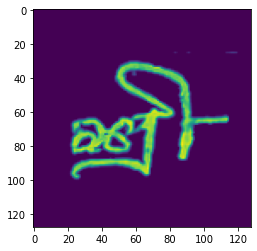

In [81]:
plt.imshow(X[0,:,:,0])

In [82]:
X,y2 = next(mygenerator1(train)) # randomly pick a row X,y1

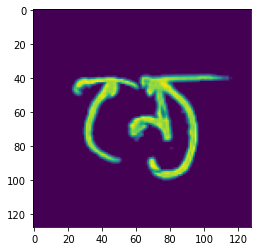

In [83]:
plt.imshow(X[0,:,:,0])

In [84]:
# https://www.kaggle.com/iafoss/image-preprocessing-128x128?select=train.zip

# Image preprocessing (128x128)

In [ ]:
# import cv2
# from tqdm import tqdm_notebook as tqdm
# import zipfile
# import io
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
# HEIGHT = 137
# WIDTH = 236
# SIZE = 128

# TRAIN = ['/kaggle/input/bengaliai-cv19/train_image_data_0.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_1.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_2.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_3.parquet']

# OUT_TRAIN = 'train.zip'

In [ ]:
# def bbox(img):
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     return rmin, rmax, cmin, cmax

# def crop_resize(img0, size=SIZE, pad=16):
#     #crop a box around pixels large than the threshold 
#     #some images contain line at the sides
#     ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
#     #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
#     return cv2.resize(img,(size,size))

In [ ]:
# df = pd.read_parquet(TRAIN[0])
# n_imgs = 8
# fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

# for idx in range(n_imgs):
#     #somehow the original input is inverted
#     img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
#     #normalize each image by its max val
#     img = (img0*(255.0/img0.max())).astype(np.uint8)
#     img = crop_resize(img)

#     axs[idx,0].imshow(img0)
#     axs[idx,0].set_title('Original image')
#     axs[idx,0].axis('off')
#     axs[idx,1].imshow(img)
#     axs[idx,1].set_title('Crop & resize')
#     axs[idx,1].axis('off')
# plt.show()

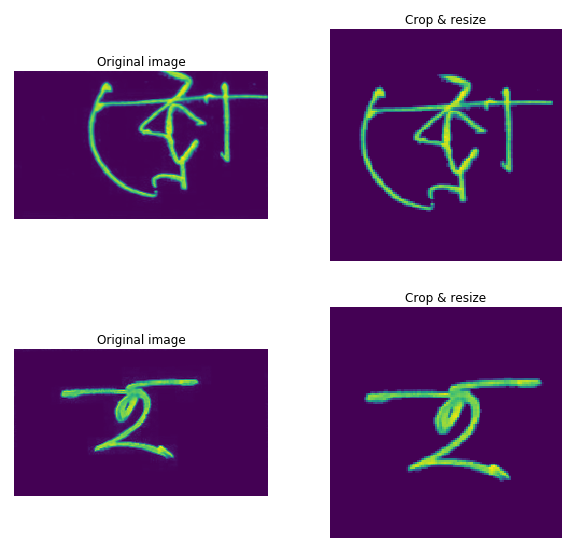

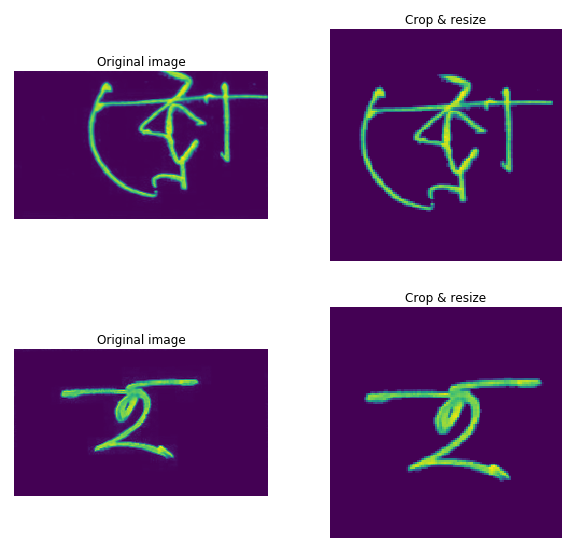

In [ ]:
# x_tot,x2_tot = [],[]
# with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
#     for fname in TRAIN:
#         df = pd.read_parquet(fname)
#         #the input is inverted
#         data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
#         for idx in tqdm(range(len(df))):
#             name = df.iloc[idx,0]
#             #normalize each image by its max val
#             img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
#             img = crop_resize(img)
        
#             x_tot.append((img/255.0).mean())
#             x2_tot.append(((img/255.0)**2).mean()) 
#             img = cv2.imencode('.png',img)[1]
#             img_out.writestr(name + '.png', img)

# Base Model of consonant_diacritic

In [85]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),    
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Dropout(rate=0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(7, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.00001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 128)     1280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)      

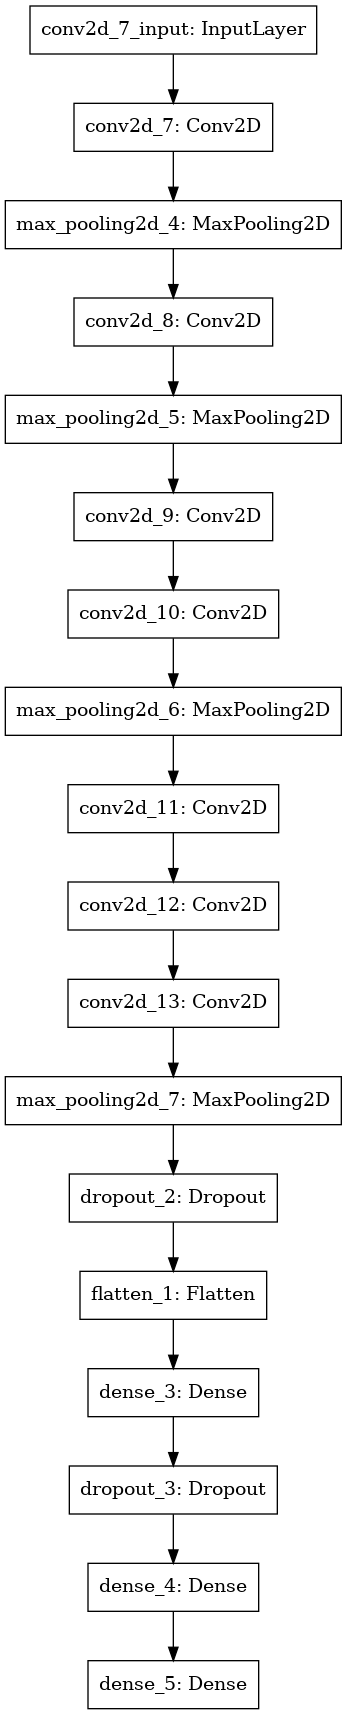

In [87]:
from keras.utils import plot_model
plot_model(model)

In [88]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=100),
    keras.callbacks.TensorBoard(log_dir='./logs')]

history = model.fit(mygenerator1(train),
                    epochs=30,
                    steps_per_epoch=180, 
                    validation_data=mygenerator1(test),
                    validation_steps=180, 
                    callbacks=my_callbacks)              


Epoch 1/30
180/180 [==============================] - 23s 125ms/step - loss: 1.6337 - accuracy: 0.5684 - recall_1: 0.4813 - val_loss: 1.2892 - val_accuracy: 0.6389 - val_recall_1: 0.6389
Epoch 2/30
180/180 [==============================] - 25s 137ms/step - loss: 1.0167 - accuracy: 0.6735 - recall_1: 0.6041 - val_loss: 1.5924 - val_accuracy: 0.6333 - val_recall_1: 0.6333
Epoch 3/30
180/180 [==============================] - 25s 137ms/step - loss: 1.4481 - accuracy: 0.5911 - recall_1: 0.4425 - val_loss: 1.2053 - val_accuracy: 0.5667 - val_recall_1: 0.4500
Epoch 4/30
180/180 [==============================] - 24s 136ms/step - loss: 1.2267 - accuracy: 0.6544 - recall_1: 0.5029 - val_loss: 1.1374 - val_accuracy: 0.6500 - val_recall_1: 0.4444
Epoch 5/30
180/180 [==============================] - 25s 136ms/step - loss: 1.0447 - accuracy: 0.6425 - recall_1: 0.5605 - val_loss: 1.1113 - val_accuracy: 0.6444 - val_recall_1: 0.6222
Epoch 6/30
180/180 [==============================] - 25s 141ms/s

In [89]:
score = model.evaluate(mygenerator1(test), steps=200,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 0.6155465841293335
Test accuracy: 0.8299999833106995


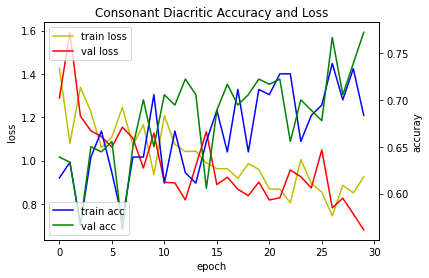

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.title('Consonant Diacritic Accuracy and Loss')
plt.show()


In [92]:
prediction = [] 
actual = []
for x,y in mygenerator1(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>1000:
        break     

In [93]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
multiclass=confusion_matrix(actual, prediction)
print(multiclass)

Confusion Matrix
[[580   5  13   0  15   1   0]
 [ 23   9   3   0   0   0   0]
 [ 37   2  87   0   0   0   0]
 [  1   0   2   0   1   0   0]
 [ 55   1   1   0  47   0   0]
 [100   0   1   0   0   9   0]
 [  4   0   0   0   3   1   0]]


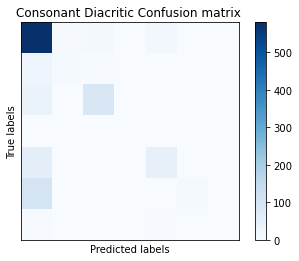

In [94]:
cm = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Consonant Diacritic Confusion matrix ')
plt.colorbar()
plt.show()


# Base Model - Vowel Diacritic

In [95]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.Dropout(rate=0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(11, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.00001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [96]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 64)       

In [97]:
my_callbacks_2 = [
    keras.callbacks.EarlyStopping(patience=100),
    keras.callbacks.TensorBoard(log_dir='./logs_2')]

history = model.fit(mygenerator2(train),
                    epochs=30,
                    steps_per_epoch=180, 
                    validation_data=mygenerator2(test),
                    validation_steps=180, 
                    callbacks=my_callbacks_2)                 


Epoch 1/30
180/180 [==============================] - 23s 126ms/step - loss: 2.1913 - accuracy: 0.1704 - recall_2: 0.0000e+00 - val_loss: 2.1545 - val_accuracy: 0.2167 - val_recall_2: 0.0000e+00
Epoch 2/30
180/180 [==============================] - 24s 135ms/step - loss: 2.1342 - accuracy: 0.2494 - recall_2: 0.0000e+00 - val_loss: 1.9722 - val_accuracy: 0.3111 - val_recall_2: 0.0111
Epoch 3/30
180/180 [==============================] - 23s 129ms/step - loss: 2.0825 - accuracy: 0.2787 - recall_2: 0.0000e+00 - val_loss: 1.9704 - val_accuracy: 0.3278 - val_recall_2: 0.0056
Epoch 4/30
180/180 [==============================] - 23s 130ms/step - loss: 1.8697 - accuracy: 0.3348 - recall_2: 0.0174 - val_loss: 1.7969 - val_accuracy: 0.4111 - val_recall_2: 0.0333
Epoch 5/30
180/180 [==============================] - 24s 134ms/step - loss: 1.7937 - accuracy: 0.3676 - recall_2: 0.0378 - val_loss: 1.8258 - val_accuracy: 0.3167 - val_recall_2: 0.1000
Epoch 6/30
180/180 [=============================

In [98]:
score = model.evaluate(mygenerator2(test), steps=1000,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 1.0217700004577637
Test accuracy: 0.6370000243186951


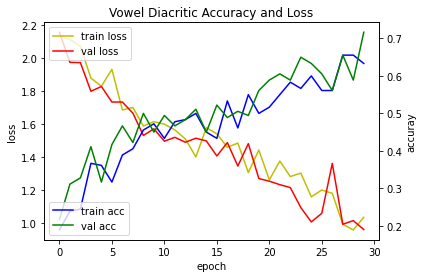

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.title('Vowel Diacritic Accuracy and Loss')
plt.show()


In [183]:
# [plt.plot(history.history[i], label=i) for i in history.history.keys()]
# plt.legend();

In [100]:
prediction = [] 
actual = []
for x,y in mygenerator2(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>1000:
        break     

In [101]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Vowel Diacritic Confusion Matrix')
cm=confusion_matrix(actual, prediction)
print(cm)

Vowel Diacritic Confusion Matrix
[[ 94  33   1   9  42   0   1  18   0   0   0]
 [  8 138   0  22   0   0   0   6   0   7   0]
 [  7   0 109   5   2   0   1  13   0   2   0]
 [  2   6   2  62   2   0   0   2   0   0   0]
 [ 12   2   0   0  78   0   0   3   0   0   0]
 [  6   0   0   0  14   0   0   3   0   0   0]
 [  6   0   0   0  13   0   0   0   0   0   0]
 [  8   2   2   1   5   0   0 123   0   4   0]
 [  1   0   2   1   1   0   0  13   3   0   0]
 [  1   5   0   4   2   0   0  25   0  41   1]
 [  0   2   0   7   0   0   0   4   0   9   3]]


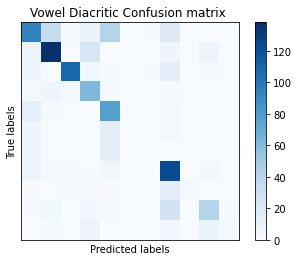

In [102]:
cm = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Vowel Diacritic Confusion matrix ')
plt.colorbar()
plt.show()


# Base Model - Grapheme Root

In [103]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.Dropout(rate=0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(168, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.00001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)       

In [105]:
my_callbacks_3 = [keras.callbacks.EarlyStopping(patience=100),
                  keras.callbacks.TensorBoard(log_dir='./logs_3')]

history = model.fit(mygenerator3(train),
                    epochs=30,
                    steps_per_epoch=180, 
                    validation_data=mygenerator3(test),
                    validation_steps=180, 
                    callbacks=my_callbacks_3)                 


Epoch 1/30
180/180 [==============================] - 23s 124ms/step - loss: 5.0691 - accuracy: 0.0573 - recall_3: 0.0000e+00 - val_loss: 4.9505 - val_accuracy: 0.0444 - val_recall_3: 0.0000e+00
Epoch 2/30
180/180 [==============================] - 24s 136ms/step - loss: 4.9640 - accuracy: 0.0284 - recall_3: 0.0000e+00 - val_loss: 4.9616 - val_accuracy: 0.0389 - val_recall_3: 0.0000e+00
Epoch 3/30
180/180 [==============================] - 24s 136ms/step - loss: 4.9150 - accuracy: 0.0428 - recall_3: 0.0000e+00 - val_loss: 4.8204 - val_accuracy: 0.0111 - val_recall_3: 0.0000e+00
Epoch 4/30
180/180 [==============================] - 24s 135ms/step - loss: 4.8490 - accuracy: 0.0307 - recall_3: 0.0000e+00 - val_loss: 4.9003 - val_accuracy: 0.0167 - val_recall_3: 0.0000e+00
Epoch 5/30
180/180 [==============================] - 25s 138ms/step - loss: 4.8526 - accuracy: 0.0447 - recall_3: 0.0000e+00 - val_loss: 4.9230 - val_accuracy: 0.0111 - val_recall_3: 0.0000e+00
Epoch 6/30
180/180 [=====

In [106]:
score = model.evaluate(mygenerator3(test), steps=200,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 4.705227375030518
Test accuracy: 0.03500000014901161


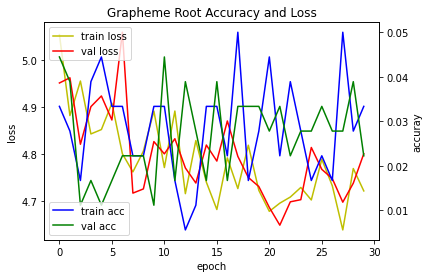

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.title('Grapheme Root Accuracy and Loss')

plt.show()


In [187]:
# [plt.plot(history.history[i], label=i) for i in history.history.keys()]
# plt.legend();

In [108]:
prediction = [] 
actual = []
for x,y in mygenerator3(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>1000:
        break     

In [109]:
len(actual)

1001

In [110]:
len(prediction)

1001

In [111]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm=confusion_matrix(actual, prediction)
print(cm)

Confusion Matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


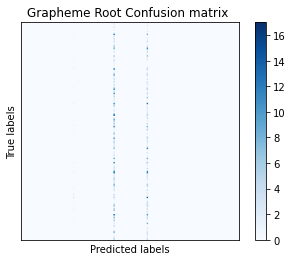

In [112]:
multiclass = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Grapheme Root Confusion matrix ')
plt.colorbar()
plt.show()


# Test Result Summary 

## Previous few times model result was ugly

    * consonant_diacritic : 
        * Test score: 2.7546441555023193
        * Test accuracy: 0.6499999761581421

    * vowel_diacritic : 
        * Test score: 1.8599588871002197
        * Test accuracy: 0.5040000081062317

    * grapheme_root : 
        * Test score: 4.7975382804870605
        * Test accuracy: 0.02500000037252903


## Tweaks
Maybe it was too deep?

- reduced layers
- reduced normalization 
- decreased learning rate from 0.0001 to 0.00001
- training epochs = 30/ steps = 180
- testing steps = 30 


## This time it did little better than random guess except graphem root 

    * consonant_diacritic :
        * Test score: 0.8095945119857788
        * Test accuracy: 0.7200000286102295

    * vowel_diacritic : 
        * Test score: 1.0217700004577637
        * Test accuracy: 0.6370000243186951

    * grapheme_root :         
        * Test score: 4.705227375030518
        * Test accuracy: 0.03500000014901161
